# AUTOENCODER
This file have purpose to anlysys performance of autoencoder model

reference : https://towardsdatascience.com/generating-new-faces-with-variational-autoencoders-d13cfcb5f0a8
## Prepare Program and Data

In [1]:
# Import library create by mysel
from directory_handle import DirectoryHandle
import image_handle as ImageHandle
import data_handle as DataHandle

# Import library for plot image
import matplotlib.pyplot as plt

# Import library for manage model part Core Layers
from keras.layers import Input, Flatten, Dense, Reshape
# Import library for manage model part Convolution Layers
from keras.layers import Conv2D, Conv2DTranspose
# Import Library for manage model part Model Object
from keras.models import Model
# Import Library for manage model part optimizer
from keras.optimizers import Adam
# Import Library about model 
from keras.utils import plot_model
# Import library for load model
from keras.models import load_model

#Import library for normal process
import numpy as np

Using TensorFlow backend.


In [2]:
# Constant data path to collect directory data
PATH_DATA = "/home/zeabus/Documents/supasan/2019_deep_learning/PokemonData" 

# Part parameter in normal program will require to input
crop = True
color = True
rounds = 10 # Round to train data (epoches)

In [3]:
# Process Read data 
directory_handle = DirectoryHandle( PATH_DATA )
list_label , list_data = directory_handle.group_data()
list_dictionary = directory_handle.group_dictionary()

smallest_size = ImageHandle.min_all_square_size1( list_data )
smallest_size = smallest_size if smallest_size % 2 == 0 else smallest_size - 1
latent_size = int( smallest_size * smallest_size / 4 )
latent_size = latent_size * 3 if color else latent_size
print(f'Will manage by resize image to smallest size {smallest_size} square and have latent size {latent_size}')

input_dim = ( smallest_size , smallest_size , 3 if color else 1 )

X_data , Y_data = ImageHandle.prepare_label_data( list_label , list_data , smallest_size , color = color , crop = crop )

Will manage by resize image to smallest size 42 square and have latent size 1323


In [4]:
# Before train data first time must split data for train and test
(X_train,Y_train) , (X_test,Y_test) = DataHandle.train_test_split( X_data , Y_data , 8 )
print(f'From {len(X_data)} datas split for train {len(X_train)} and test {len(X_test)}')

From 6781 datas split for train 5934 and test 847


## Model Part
Above part is part prepare data for train test and analysis

In [25]:
# Set up model part encoder
encoder_input = Input( shape = input_dim , name = 'encode_input' )
encoder = encoder_input
encoder = Conv2D( filters = 64,
                kernel_size = (3,3),
                strides=2,
                padding='same',
                activation='relu',
                name = "encoder_convolution_1")(encoder)
encoder = Conv2D( filters = 32,
                kernel_size = (3,3),
                strides=1,
                padding='same',
                activation='relu',
                name = "encoder_convolution_2")(encoder)
encoder = Conv2D( filters = 16,
                kernel_size = (3,3),
                strides=1,
                padding='same',
                activation='relu',
                name = "encoder_convolution_3")(encoder)
shape_before_flatten = (int(smallest_size/2) , int(smallest_size/2) , 16)
encoder = Flatten()(encoder)
encoder_output = Dense( latent_size , name = "encoder_output")(encoder)

encoder_model = Model( encoder_input , encoder_output )
encoder_model.name = "encoder_model"
encoder_model.summary()

Model: "encoder_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encode_input (InputLayer)    (None, 42, 42, 3)         0         
_________________________________________________________________
encoder_convolution_1 (Conv2 (None, 21, 21, 64)        1792      
_________________________________________________________________
encoder_convolution_2 (Conv2 (None, 21, 21, 32)        18464     
_________________________________________________________________
encoder_convolution_3 (Conv2 (None, 21, 21, 16)        4624      
_________________________________________________________________
flatten_1 (Flatten)          (None, 7056)              0         
_________________________________________________________________
encoder_output (Dense)       (None, 1323)              9336411   
Total params: 9,361,291
Trainable params: 9,361,291
Non-trainable params: 0
___________________________________________

In [26]:
decoder_input = Input( shape = (latent_size,) , name ='decoder_input')
decoder = Dense( np.prod(shape_before_flatten) , name='decoder_input_convolution' )(decoder_input)
decoder = Reshape( shape_before_flatten , name='decoder_input_reshape')(decoder)
decoder = Conv2DTranspose( filters = 32,
                        kernel_size = (3,3),
                        strides=1,
                        padding='same',
                        name='decoder_convolution_1',
                        activation='relu')(decoder)
decoder = Conv2DTranspose( filters = 64,
                        kernel_size = (3,3),
                        strides=2,
                        padding='same',
                        name='decoder_convolution_2',
                        activation='relu')(decoder)
decoder_output = Conv2DTranspose( filters = 3 if color else 1,
                        kernel_size = (3,3),
                        strides=1,
                        padding='same',
                        name='decoder_output',
                        activation='relu')(decoder)
decoder_model = Model( decoder_input , decoder_output )
decoder_model.name = "decoder_model"
decoder_model.summary()

Model: "decoder_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 1323)              0         
_________________________________________________________________
decoder_input_convolution (D (None, 7056)              9342144   
_________________________________________________________________
decoder_input_reshape (Resha (None, 21, 21, 16)        0         
_________________________________________________________________
decoder_convolution_1 (Conv2 (None, 21, 21, 32)        4640      
_________________________________________________________________
decoder_convolution_2 (Conv2 (None, 42, 42, 64)        18496     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 42, 42, 3)         1731      
Total params: 9,367,011
Trainable params: 9,367,011
Non-trainable params: 0
___________________________________________

In [27]:
autoencoder = Model( encoder_input , decoder_model(encoder_output) )
autoencoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encode_input (InputLayer)    (None, 42, 42, 3)         0         
_________________________________________________________________
encoder_convolution_1 (Conv2 (None, 21, 21, 64)        1792      
_________________________________________________________________
encoder_convolution_2 (Conv2 (None, 21, 21, 32)        18464     
_________________________________________________________________
encoder_convolution_3 (Conv2 (None, 21, 21, 16)        4624      
_________________________________________________________________
flatten_1 (Flatten)          (None, 7056)              0         
_________________________________________________________________
encoder_output (Dense)       (None, 1323)              9336411   
_________________________________________________________________
decoder_model (Model)        (None, 42, 42, 3)         9367

## Train Model

In [8]:
optimizer = Adam( lr = 0.0005 ) # set learning
autoencoder.compile( optimizer=optimizer,
                    loss='mean_squared_error',
                    metrics=['accuracy'])
history = autoencoder.fit( [X_train], # Input
                          [X_train], # Output
                         validation_data=( [X_test] , [X_test]),
                         epochs = rounds )

Train on 5934 samples, validate on 847 samples
Epoch 1/10
5934/5934 [==============================] - 103s 17ms/step - loss: 5196.3642 - accuracy: 0.4236 - val_loss: 3124.9532 - val_accuracy: 0.4413
Epoch 2/10
5934/5934 [==============================] - 100s 17ms/step - loss: 2500.1494 - accuracy: 0.5641 - val_loss: 2103.3345 - val_accuracy: 0.5818
Epoch 3/10
5934/5934 [==============================] - 104s 17ms/step - loss: 1906.4375 - accuracy: 0.6147 - val_loss: 1835.2570 - val_accuracy: 0.6162
Epoch 4/10
5934/5934 [==============================] - 96s 16ms/step - loss: 1652.1814 - accuracy: 0.6381 - val_loss: 1546.0496 - val_accuracy: 0.6840
Epoch 5/10
5934/5934 [==============================] - 97s 16ms/step - loss: 1442.0731 - accuracy: 0.6672 - val_loss: 1433.1331 - val_accuracy: 0.7349
Epoch 6/10
5934/5934 [==============================] - 97s 16ms/step - loss: 1306.6769 - accuracy: 0.6899 - val_loss: 1310.1459 - val_accuracy: 0.6832
Epoch 7/10
5934/5934 [================

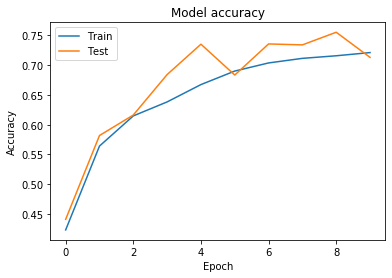

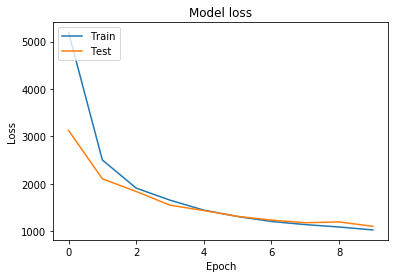

In [9]:
# Plot traing & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [10]:
autoencoder.save( "pokemon_autoencoder.h5")

## Result Model

In [51]:
autoencoder = load_model( "pokemon_autoencoder.h5" )

In [8]:
random_index = []
for _ in range(0,10):
    random_index.append( np.random.randint( len( X_test)))
random_index = tuple( set( random_index ) )
data = []
for index in random_index :
    data.append( X_test[ index ] )
data = np.array( data )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


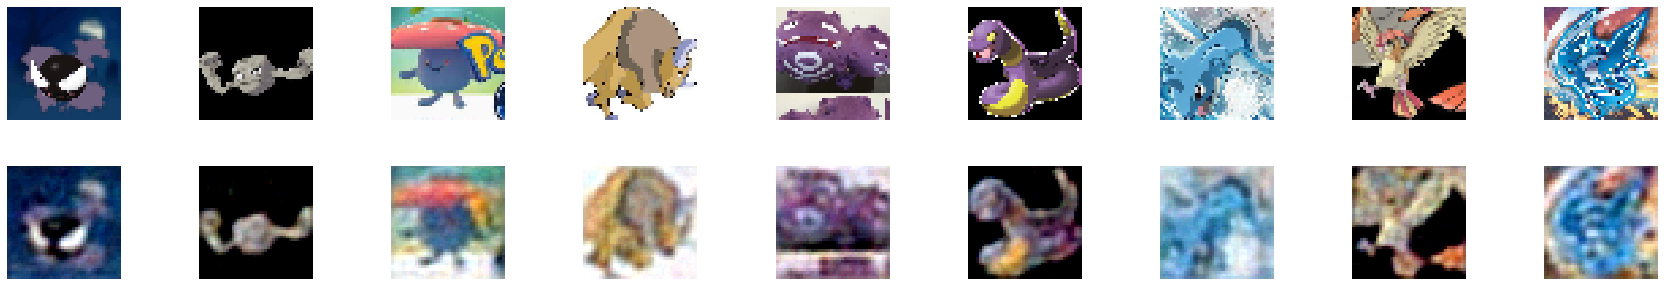

In [9]:
DataHandle.plot_compare( data , autoencoder , (30,5))

# Part Classifier
Above part is model for autoencoder below part will push Fully Connected Layer for classifier

In [39]:
classifier_input = Input( shape = (latent_size,) , name = "classifier_input" )
classifier = Dense( int( latent_size / 2 ), 
        activation='relu',
        name = 'classifier_network_1' )( classifier_input )
classifier_output = Dense( len(list_label),
        activation='softmax',
        name = 'classifier_output' )( classifier )

classifier_model = Model( classifier_input , classifier_output )
classifier_model.name = "fully_connected"
classifier_model.summary()

Model: "fully_connected"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
classifier_input (InputLayer (None, 1323)              0         
_________________________________________________________________
classifier_network_1 (Dense) (None, 661)               875164    
_________________________________________________________________
classifier_output (Dense)    (None, 149)               98638     
Total params: 973,802
Trainable params: 973,802
Non-trainable params: 0
_________________________________________________________________


In [65]:
classifier = Model( encoder_input , classifier_model( encoder_output ) )
classifier.name = "classifier_model"
optimizer = Adam( lr = 0.0005 ) # set learning
classifier.compile( optimizer=optimizer,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
classifier.summary()

Model: "classifier_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encode_input (InputLayer)    (None, 42, 42, 3)         0         
_________________________________________________________________
encoder_convolution_1 (Conv2 (None, 21, 21, 64)        1792      
_________________________________________________________________
encoder_convolution_2 (Conv2 (None, 21, 21, 32)        18464     
_________________________________________________________________
encoder_convolution_3 (Conv2 (None, 21, 21, 16)        4624      
_________________________________________________________________
flatten_1 (Flatten)          (None, 7056)              0         
_________________________________________________________________
encoder_output (Dense)       (None, 1323)              9336411   
_________________________________________________________________
fully_connected (Model)      (None, 149)          

In [63]:
# Next we will save weights
for run in range( 0 , len( classifier.layers ) - 1 ):
    classifier.layers[ run ].set_weights( autoencoder.layers[run].get_weights() )
    classifier.layers[ run ].trainable = False
classifier.summary()

Model: "classifier_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encode_input (InputLayer)    (None, 42, 42, 3)         0         
_________________________________________________________________
encoder_convolution_1 (Conv2 (None, 21, 21, 64)        1792      
_________________________________________________________________
encoder_convolution_2 (Conv2 (None, 21, 21, 32)        18464     
_________________________________________________________________
encoder_convolution_3 (Conv2 (None, 21, 21, 16)        4624      
_________________________________________________________________
flatten_1 (Flatten)          (None, 7056)              0         
_________________________________________________________________
encoder_output (Dense)       (None, 1323)              9336411   
_________________________________________________________________
fully_connected (Model)      (None, 149)          

In [67]:
history = classifier.fit( [X_train], # Input
                          [Y_train], # Output
                         validation_data=( [X_test] , [Y_test]),
                         epochs = rounds )

Train on 5934 samples, validate on 847 samples
Epoch 1/10
5934/5934 [==============================] - 14s 2ms/step - loss: 2.9695 - accuracy: 0.5170 - val_loss: 17.0420 - val_accuracy: 0.1157
Epoch 2/10
5934/5934 [==============================] - 15s 3ms/step - loss: 2.5587 - accuracy: 0.5501 - val_loss: 16.9838 - val_accuracy: 0.1157
Epoch 3/10
5934/5934 [==============================] - 15s 3ms/step - loss: 2.0322 - accuracy: 0.6138 - val_loss: 16.6937 - val_accuracy: 0.1322
Epoch 4/10
5934/5934 [==============================] - 16s 3ms/step - loss: 1.8453 - accuracy: 0.6385 - val_loss: 17.2613 - val_accuracy: 0.1429
Epoch 5/10
5934/5934 [==============================] - 17s 3ms/step - loss: 1.5883 - accuracy: 0.6778 - val_loss: 18.1002 - val_accuracy: 0.1499
Epoch 6/10
5934/5934 [==============================] - 16s 3ms/step - loss: 1.4870 - accuracy: 0.6926 - val_loss: 18.6386 - val_accuracy: 0.1535
Epoch 7/10
5934/5934 [==============================] - 17s 3ms/step - loss: 

In [68]:
classifier.save( "pokemon_autoencoder_classifier.h5")

## Result Model Classifier on AutoEncoder

In [5]:
classifier = load_model( "pokemon_autoencoder_classifier.h5" )
predict = classifier.predict( [X_test] )

In [6]:
DataHandle.result_classifier( predict , np.array( Y_test ) , list_dictionary )

Report classifier system 847 datas
Name                     |      PRECISION |         RECALL
-------------------------------------------------------------------------------
Alakazam                 |        0.00000 |        0.00000
Diglett                  |        0.00000 |        0.00000
Tauros                   |        0.11111 |        0.16667
Poliwrath                |        0.00000 |        0.00000
Jynx                     |        0.75000 |        0.50000
Machop                   |        0.25000 |        0.33333
Abra                     |        0.00000 |        0.00000
Voltorb                  |        0.55556 |        0.71429
Golbat                   |        0.00000 |        0.00000
Magneton                 |        0.00000 |        0.00000
Gloom                    |        0.33333 |        0.33333
Alolan Sandslash         |        0.00000 |        0.00000
Kangaskhan               |        0.00000 |        0.00000
Horsea                   |        0.00000 |        0.00000


/home/zeabus/Documents/supasan/2019_deep_learning/deep_learning_project/src_classifier/data_handle.py:64: RuntimeWarning: invalid value encountered in double_scalars
  precision[ run ] = correct[run] / precision[ run ]


In [7]:
list_dictionary

{0: 'Alakazam',
 1: 'Diglett',
 2: 'Tauros',
 3: 'Poliwrath',
 4: 'Jynx',
 5: 'Machop',
 6: 'Abra',
 7: 'Voltorb',
 8: 'Golbat',
 9: 'Magneton',
 10: 'Gloom',
 11: 'Alolan Sandslash',
 12: 'Kangaskhan',
 13: 'Horsea',
 14: 'Graveler',
 15: 'Venomoth',
 16: 'Krabby',
 17: 'Porygon',
 18: 'Gyarados',
 19: 'Cloyster',
 20: 'Raichu',
 21: 'Venonat',
 22: 'Bellsprout',
 23: 'Shellder',
 24: 'Exeggcute',
 25: 'Pikachu',
 26: 'Kabutops',
 27: 'Rhyhorn',
 28: 'Blastoise',
 29: 'Nidorino',
 30: 'Growlithe',
 31: 'Weezing',
 32: 'Persian',
 33: 'Vaporeon',
 34: 'Weepinbell',
 35: 'Spearow',
 36: 'Drowzee',
 37: 'Pidgeot',
 38: 'Scyther',
 39: 'Zubat',
 40: 'Tentacruel',
 41: 'Slowpoke',
 42: 'Gengar',
 43: 'Kakuna',
 44: 'Arbok',
 45: 'Venusaur',
 46: 'Primeape',
 47: 'Electabuzz',
 48: 'Hypno',
 49: 'Cubone',
 50: 'Beedrill',
 51: 'Omanyte',
 52: 'Flareon',
 53: 'Rattata',
 54: 'Pinsir',
 55: 'Charizard',
 56: 'Ninetales',
 57: 'Vileplume',
 58: 'Charmander',
 59: 'Goldeen',
 60: 'Aerodactyl',
